# Step 1: Getting the data

In [2]:
# Make sure that we use SageMaker 1.x
!pip install sagemaker==1.72.0

In [3]:
# Uncomment when working with colab

# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Uncomment when working with colab

# Insert the directory to import custom modules

# import sys
# sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/nlp')

In [5]:
# Uncomment when working with colab

# path = '/content/drive/My Drive/IMDB_spoiler_dataset/'

In [6]:
%mkdir ../data
import os
import glob
import pandas as pd

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))

from collections import Counter

mkdir: cannot create directory ‘../data’: File exists


In [7]:
# Getting data from amazon bucket

bucket='imdb-review-dataset'
data_key = 'IMDB_reviews.json'
data_location = 's3://{}/{}'.format(bucket, data_key)

train_data = pd.read_json(data_location)

In [8]:
# Uncomment when working with colab

# train_data = pd.read_json(path + 'IMDB_reviews.json', lines=True).\
#                           drop_duplicates('review_text').sample(frac=1)

In [9]:
print(train_data.shape)
train_data.head()

(200000, 7)


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
144622,7 May 2007,tt0414993,ur0730831,False,It wouldn't be wrong to say that here in the U...,8,A masterpiece
114926,17 January 2001,tt0137523,ur0991805,False,I think this is one of the best movies ever. T...,10,SUPER !!!!
150839,3 August 2017,tt2239822,ur79060296,False,What a good film. Maybe the best European Film...,10,One of the best Sci-Fi Films ever.....
66719,23 June 1999,tt0066921,ur0361577,True,I thought that this movie was awful. I was so...,1,Ick.
31773,16 July 2005,tt0367594,ur4433753,True,Anytime Tim Burton and Johnny Depp get togethe...,7,A wonderful adventure


# Step 2: Preparing and Processing the data

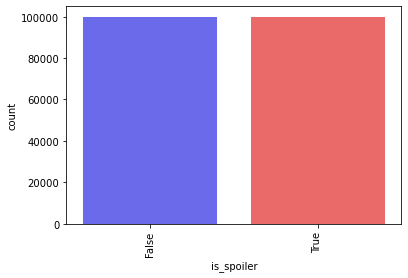

In [10]:
sns.countplot(x=train_data.is_spoiler, order=[x for x, count in sorted(Counter(train_data.is_spoiler).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

In [11]:
# Uncomment when working with colab

# spoiler_data = train_data[train_data["is_spoiler"]==True][:100000]
# non_spoiler_data = train_data[train_data["is_spoiler"]==False][:100000]

In [12]:
# Uncomment when working with colab

# print(spoiler_data.shape)
# print(non_spoiler_data.shape)

In [13]:
# Uncomment when working with colab

# spoiler_data.head()

In [14]:
# Uncomment when working with colab

# non_spoiler_data.head()

Now that we've managed to minimize our dataset, we will combine the positive and negative reviews and shuffle the resulting records and prepare training and test data.

In [15]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X = train_data["review_text"]
y = list(map(lambda x: 0 if x==False else 1, train_data["is_spoiler"]))

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
# Uncomment when working with colab


# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

# def prepare_imdb_data(spoiler, not_spoiler):
#     """Prepare training and test sets from IMDb movie reviews."""
    
#     #Combine spoiler and non_spoiler dataset
#     all_data = pd.concat([spoiler, not_spoiler], ignore_index=True)
    
#     # Shuffle data
#     all_data = all_data.sample(frac=1)

#     # Get Review and label
#     X = all_data["review_text"]
#     y = list(map(lambda x: 0 if x==False else 1, all_data["is_spoiler"]))
#     # Train test split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

#     return X_train, X_test, y_train, y_test

In [16]:
# Uncomment when working with colab

# X_train, X_test, y_train, y_test = prepare_imdb_data(spoiler_data, non_spoiler_data)
# print("IMDb reviews (combined): train = {}, test = {}".format(len(X_train), len(X_test)))

In [17]:
X_train.head()

17872     Not different from BvS, plot and pace wise, bu...
98736     2012 is full of misconceptions and other stuff...
143561    Well, I can say is that I don't see this movie...
21229     This is really pretty bad. It's a blatant atte...
170620    American Beauty (1999) D: Sam Mendes. Kevin Sp...
Name: review_text, dtype: object

In [18]:
y_train[:5]

[1, 1, 0, 1, 0]

In [19]:
print(X_train[:1])
print(y_train[:1])

17872    Not different from BvS, plot and pace wise, bu...
Name: review_text, dtype: object
[1]


The first step in processing the reviews is to make sure that any symbols or tags that appear should be removed. In addition we wish to tokenize our input, that way words such as *entertained* and *entertaining* are considered the same with regard to sentiment analysis. The `review_to_words` method defined above uses the nltk package to tokenize the reviews.

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    # Clean the text
    text = str(review)
    text = text.lower()
    
    text = re.sub(r"[^A-Za-z0-9^,!:.\/'+-=]", " ", text)


    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

The method below applies the `review_to_words` method to each of the reviews in the training and testing datasets. In addition it caches the results. This is because performing this processing step can take a long time. This way if you are unable to complete the notebook in the current session, you can come back without needing to process the data a second time.

In [21]:
import pickle

cache_dir = os.path.join("../cache", "spoiler_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [22]:
# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(X_train, X_test, y_train, y_test)

Read preprocessed data from cache file: preprocessed_data.pkl


In [23]:
# Clean our memory

import gc

del train_data
gc.collect()

0

## Transform the data

For the model we are going to construct in this notebook we will construct a feature representation which is very similar to bag-of-words. To start, we will represent each word as an integer. Of course, some of the words that appear in the reviews occur very infrequently and so likely don't contain much information for the purposes of the review analysis. The way we will deal with this problem is that we will fix the size of our working vocabulary and we will only include the words that appear most frequently. We will then combine all of the infrequent words into a single category and, in our case, we will label it as 1.

Since we will be using a recurrent neural network, it will be convenient if the length of each review is the same. To do this, we will fix a size for our reviews and then pad short reviews with the category 'no word' (which we will label 0) and truncate long reviews.

To begin with, we need to construct a way to map words that appear in the reviews to integers. Here we fix the size of our vocabulary (including the 'no word' and 'infrequent' categories) to be `5000` but you may wish to change this to see how it affects the model.

 Note that even though the vocab_size is set to 5000, we only want to construct a mapping for the most frequently appearing 4998 words. This is because we want to reserve the special labels `0` for 'no word' and `1` for 'infrequent word'.

In [24]:
import numpy as np

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    # sentence is a list of words.
    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur
    
    for review in data:
        for word in review:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
    # Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    # sorted_words[-1] is the least frequently appearing word.
    
    sorted_words = None
    sorted_words = sorted(word_count, key=word_count.get, reverse=True)
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word' and
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [25]:
word_dict = build_dict(X_train)

Let's see the most frequent words in our dataset.

In [26]:
count = 0
for word in word_dict:
    print(word)
    if count > 4:
        break
    count += 1

movi
film
like
one
make
see


## Save `word_dict`

Later on when we construct an endpoint which processes a submitted review we will need to make use of the `word_dict` which we have created. As such, we will save it to a file now for future use.

In [27]:
data_dir = '../data/pytorch' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

In [28]:
with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

## Transform the reviews

Now that we have our word dictionary which allows us to transform the words appearing in the reviews into integers, it is time to make use of it and convert our reviews to their integer sequence representation, making sure to pad or truncate to a fixed length, which in our case is `500`.

In [29]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [30]:
X_train, X_train_len = convert_and_pad_data(word_dict, X_train)
X_test, X_test_len = convert_and_pad_data(word_dict, X_test)

As a quick check to make sure that things are working as intended, check to see what one of the reviews in the training set looks like after having been processeed.

In [31]:
# Use this cell to examine one of the processed reviews to make sure everything is working as intended.
X_train[100]

array([   1, 2901,  597,    1,    1,  324,  135,   57,   64,  576,   31,
         14,    9, 1104,  196,  524,   12,   67,  225,  275,  161,  888,
         43,    2,   97,    1,  743,  736,  743,  700,  454,  147,  727,
       1773,  467,   55,  460,   83,    1, 2563,  135,   46,    1,    1,
        808,  199,  672,  144, 2569, 2569,  530,    1, 2252, 4061,  284,
         73,    2,    1,    6,    1,  533,  456,    2,   48,   14,   15,
        147,   77, 1693,    1,    2, 1067,  430,  292, 1643,    1,  135,
       1668, 3390,  147,   20,    1, 2431,  147,    4,    1,    1,    1,
          1, 2909,   23,  397,    1,  264,   39, 4029,  112,    1,    1,
        224,   66,   43,  841,    1, 3923,  134, 4335,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

# Step 3: Upload the data to S3

We will need to upload the training dataset to S3 in order for our training code to access it. For now we will save it locally and we will upload to S3 later on.



## Save the processed training dataset locally
It is important to note the format of the data that we are saving as we will need to know it when we write the training code. In our case, each row of the dataset has the form `label`, `length`, `review[500]` where `review[500]` is a sequence of `500` integers representing the words in the review.

In [32]:
import pandas as pd
    
pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train_len), pd.DataFrame(X_train)], axis=1) \
        .to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

## Uploading the training data

Next, we need to upload the training data to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [33]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sentiment_rnn'

role = sagemaker.get_execution_role()

In [34]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

**NOTE**: The cell above uploads the entire contents of our data directory. This includes the word_dict.pkl file. This is fortunate as we will need this later on when we create an endpoint that accepts an arbitrary review. For now, we will just take note of the fact that it resides in the data directory (and so also in the S3 training bucket) and that we will need to make sure it gets saved in the model directory.

# Step 4: Build and Train the PyTorch Model

Our model is in the SageMaker framework comprises three objects

- Model Artifacts,
- Training Code, and
- Inference Code,

each of which interact with one another. We will be using training and inference code containers provided by Amazon with the added benefit of being able to include our own custom code.

We will start by implementing our own neural network in PyTorch along with a training script. For the purposes of this project we have provided the necessary model object in the `model.py` file, inside of the train folder. You can see the provided implementation by running the cell below.

In [35]:
!pygmentize train/model.py

import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=1)
        self.sig = nn.Sigmoid()
        
        self.word_dict = None

    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = x.t()
        lengths = x[0,:]
        reviews = x[1:,:]
        embeds = self.embedding(reviews)
        lstm_out, _ = self.lstm(embeds)
        out = self.dense(lstm_out)
        out = out[lengths - 1, range(len(lengths))]
        return self.sig

The important takeaway from the implementation provided is that there are three parameters that we may wish to tweak to improve the performance of our model. These are the embedding dimension, the hidden dimension and the size of the vocabulary. We will likely want to make these parameters configurable in the training script so that if we wish to modify them we do not need to modify the script itself. We will see how to do this later on. To start we will write some of the training code in the notebook so that we can more easily diagnose any issues that arise.

First we will load a small portion of the training data set to use as a sample. It would be very time consuming to try and train the model completely in the notebook as we do not have access to a gpu and the compute instance that we are using is not particularly powerful. However, we can work on a small bit of the data to get a feel for how our training script is behaving.

In [36]:
import torch
import torch.utils.data

# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=250)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

In [37]:
train_sample[0]

0      0
1      0
2      1
3      1
4      0
      ..
245    1
246    0
247    1
248    0
249    1
Name: 0, Length: 250, dtype: int64

## Writing the training method

Next we need to write the training code itself. We will be using Facebooks **Pytorch** model.

In [38]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            out = model.forward(batch_X)
            loss = loss_fn(out, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))

Supposing we have the training method above, we will test that it is working by writing a bit of code in the notebook that executes our training method on the small sample training set that we loaded earlier. The reason for doing this in the notebook is so that we have an opportunity to fix any errors that arise early when they are easier to diagnose.

In [39]:
import torch.optim as optim
from train.model import LSTMClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device {}".format(device))
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

train(model, train_sample_dl, 5, optimizer, loss_fn, device)

Using device cpu
Epoch: 1, BCELoss: 0.6939353704452514
Epoch: 2, BCELoss: 0.6867759466171265
Epoch: 3, BCELoss: 0.6805546045303345
Epoch: 4, BCELoss: 0.6729208827018738
Epoch: 5, BCELoss: 0.6617103576660156


In order to construct a PyTorch model using SageMaker we must provide SageMaker with a training script. We may optionally include a directory which will be copied to the container and from which our training code will be run. When the training container is executed it will check the uploaded directory (if there is one) for a `requirements.txt` file and install any required Python libraries, after which the training script will be run.

## Training the model

When a PyTorch model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained. Inside of the train directory is a file called `train.py` which contains most of the necessary code to train our model.

The way that SageMaker passes hyperparameters to the training script is by way of arguments. These arguments can then be parsed and used in the training script.

In [47]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='1.0.0',
                    py_version='py3',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 20,
                        'hidden_dim': 100,
                    })

In [48]:
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-05-05 15:49:08 Starting - Starting the training job...
2021-05-05 15:49:10 Starting - Launching requested ML instances.........
2021-05-05 15:50:39 Starting - Preparing the instances for training.........
2021-05-05 15:52:25 Downloading - Downloading input data...
2021-05-05 15:52:52 Training - Downloading the training image....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-05-05 15:53:42,652 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-05-05 15:53:42,681 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-05-05 15:53:42,683 sagemaker_pytorch_container.training INFO     Invoking user training script.

2021-05-05 15:53:41 Training - Training image download completed. Training in progress.2021-05-05 15:54:05,791 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2021-05-05 15:54:05,791 s

Model loaded with embedding_dim 32, hidden_dim 100, vocab_size 5000.
Epoch: 1, BCELoss: 0.6917371319505734
Epoch: 2, BCELoss: 0.6883836622817067
Epoch: 3, BCELoss: 0.6877211250436192
Epoch: 4, BCELoss: 0.6849505537615036
Epoch: 5, BCELoss: 0.685792413953775
Epoch: 6, BCELoss: 0.6680911802255307
Epoch: 7, BCELoss: 0.6849544648164377
Epoch: 8, BCELoss: 0.6690508031997436
Epoch: 9, BCELoss: 0.6555844712942934
Epoch: 10, BCELoss: 0.6740759030317727
Epoch: 11, BCELoss: 0.6747348605634306
Epoch: 12, BCELoss: 0.6479934528232002
Epoch: 13, BCELoss: 0.6255756268105187
Epoch: 14, BCELoss: 0.603450575575661
Epoch: 15, BCELoss: 0.587893191998759
Epoch: 16, BCELoss: 0.5779725935893317
Epoch: 17, BCELoss: 0.5712389826012877
Epoch: 18, BCELoss: 0.5660143157544608
Epoch: 19, BCELoss: 0.560884275756324
Epoch: 20, BCELoss: 0.5560147640423272
2021-05-05 16:13:28,145 sagemaker-containers INFO     Reporting training SUCCESS

2021-05-05 16:14:28 Uploading - Uploading generated training model
2021-05-05 16:1

# Step 5: Testing the model
As mentioned at the top of this notebook, we will be testing this model by first deploying it and then sending the testing data to the deployed endpoint. We will do this so that we can make sure that the deployed model is working correctly.

# Step 6: Deploy the model for testing

Now that we have trained our model, we would like to test it to see how it performs. Currently our model takes input of the form `review_length`, `review[500]` where `review[500]` is a sequence of `500` integers which describe the words present in the review, encoded using word_dict. Fortunately for us, SageMaker provides built-in inference code for models with simple inputs such as this.

There is one thing that we need to provide, however, and that is a function which loads the saved model. This function must be called model_fn() and takes as its only parameter a path to the directory where the model artifacts are stored. This function must also be present in the python file which we specified as the entry point. 


**NOTE**: When deploying a model you are asking SageMaker to launch an compute instance that will wait for data to be sent to it. As a result, this compute instance will continue to run until you shut it down. This is important to know since the cost of a deployed endpoint depends on how long it has been running for.


In [49]:
# Deploy the trained model
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!

# Step 7 - Use the model for testing

Once deployed, we can read in the test data and send it off to our deployed model to get some results. Once we collect all of the results we can determine how accurate our model is.

In [50]:
X_test = pd.concat([pd.DataFrame(X_test_len), pd.DataFrame(X_test)], axis=1)

In [51]:
# We split the data into chunks and send each chunk seperately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [52]:
predictions = predict(X_test.values)
predictions = [round(num) for num in predictions]

In [53]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.68375

Our accuracy is a little bit low compared to the traditional ML models we used before. But this could be improved if we trained for more epoches. For now we will leave it as it is and continue with our test with the trained model. Once everything is OK we can retrain given that we won't be ending up with a higher bill.

## More testing
We now have a trained model which has been deployed and which we can send processed reviews to and which returns the predicted sentiment. However, ultimately we would like to be able to send our model an unprocessed review. That is, we would like to send the review itself as a string. 

The question we now need to answer is, how do we send this review to our model?

Recall in the first section of this notebook we did a bunch of data processing to the IMDb dataset. In particular, we did a specific things to the provided reviews, which is encoding the review as a sequence of integers using `word_dict`. In order process the review we will need to repeat these step.



We will be taking one of the reviews that the model didn't train on from our dataset.

In [54]:
test_review = "I see that this movie came out in 1999, but I don't remember it coming out on the big screens? I bought the DVD on Amazon and loved the movie, I guess because I am a huge William Fichtner fan. The movie is different in a way because it has three separate stories, involving four different character's from the movie. Even though there are three separate stories of the individual's it all connect's in the end. In the first story we have a Ronnin who is short on rent money and if she doesn't come up with something to make a quick money will be thrown out of her apartment. She hooks up with a drug dealer, she scores the cash, but D***S him over. When he finds out he shows up at a rave where she's at, he finds he and confronts her. Her story ends when she accidentally gets hit by a car.The next story is about Simion the British guy, who gets to go with his friends to Las Vegas. All is going well with his buds, until, he and Taye Diggs character decide to go to a strip club called The Crazy Horse.. Taye Digg's character warned him order anything U want except Champaign-means private dance.When the ladies come over to greet them Simon gets stupid and asks for the most expensive bottle of Champaign. Simon gets his private dance and more than he bargained for. The rules the girls can touch U but U can't touch the girls. The rule gets broken, things get out of hand and Simon pulls out a gun and shoots a bouncer. When this happens the whole gang gets involved and are trying to get the hell out of Vegas, because they are wanted. This was an OK story, but in reality very unrealistic.The third about Adam and Zack is the best, it's about to actor's who are used as pawns to catch a drug dealer in the act of selling. Adam and Zack go along with it because an offense will be expunged from their record if all goes as planned. They met up with Burke, a cop or ex-cop who still has connections to the department. We then realize the 1st and 3rd stories come together, in the end. Then the 2nd story ties in with some of the characters in the 1st story.I hope this review is helpful, it is hard to explain a movie like this. To me it is a good movie, to rent, or one to buy if the price is right. The only drawback it might have is yes it is unrealistic, but most movies are. This movie is one to watch when U had a hard day/busy one and just want to chill 4 about 2 hours.It does have it's comedic side to it, but for those that do not like several stories told in one movie, even though they all connect in the end; this would not be for you. THX, -Kris L. CocKayne"

In [55]:
# Convert test_review into a form usable by the model and save the results in test_data
test_data = review_to_words(test_review)
test_data = [np.array(convert_and_pad(word_dict, test_data)[0])]

Now that we have processed the review, we can send the resulting array to our model to predict the sentiment of the review.

In [56]:
predictor.predict(test_data)

array(0.1940709, dtype=float32)

Since the return value of our model is close to 0, our model is infering the inpute is not a spoiler eventhough it is. This shows why our model still needs training. Let's leave this as is and continue with our work.

**NOTE**: Inorder not to end up with high bill we're gonna stop our endpoint now.

In [57]:
estimator.delete_endpoint()

estimator.delete_endpoint() will be deprecated in SageMaker Python SDK v2. Please use the delete_endpoint() function on your predictor instead.


# Step 6 - Deploy the model for the web app

Now that we know that our model is working, it's time to create some custom inference code so that we can send the model a review which has not been processed and have it determine the sentiment of the review.

As we saw above, by default the estimator which we created, when deployed, will use the entry script and directory which we provided when creating the model. However, since we now wish to accept a string as input and our model expects a processed review, we need to write some custom inference code.

We will store the code that we write in the `serve` directory. Provided in this directory is the `model.py` file that we used to construct our model, a `utils.py` file which contains the `review_to_words` and `convert_and_pad` pre-processing functions which we used during the initial data processing, and `predict.py`, the file which will contain our custom inference code. Note also that `requirements.txt` is present which will tell SageMaker what Python libraries are required by our custom inference code.

When deploying a PyTorch model in SageMaker, you are expected to provide four functions which the SageMaker inference container will use.

- `model_fn`: This function is the same function that we used in the training script and it tells SageMaker how to load our model.
- `input_fn`: This function receives the raw serialized input that has been sent to the model's endpoint and its job is to de-serialize and make the input available for the inference code.
- `output_fn`: This function takes the output of the inference code and its job is to serialize this output and return it to the caller of the model's endpoint.
- `predict_fn`: The heart of the inference script, this is where the actual prediction is done and is the function which you will need to complete.

For the simple website that we are constructing during this project, the `input_fn` and `output_fn` methods are relatively straightforward. We only require being able to accept a string as input and we expect to return a single value as output. You might imagine though that in a more complex application the input or output may be image data or some other binary data which would require some effort to serialize.

## Writing inference code

We have written the inference code and save it into the serve directory. We can see the content of the file here.

In [58]:
!pygmentize serve/predict.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from model import LSTMClassifier

from utils import review_to_words, convert_and_pad

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(model_info['embedding_dim'], model_info['hidden_dim'], model_info['vocab_size'])

    # Load the store model parameters.
    model_path = os.path.join(mod

## Deploying the model
Now that the custom inference code has been written, we will create and deploy our model. To begin with, we need to construct a new PyTorchModel object which points to the model artifacts created during training and also points to the inference code that we wish to use. Then we can call the deploy method to launch the deployment container.

**NOTE**: The default behaviour for a deployed PyTorch model is to assume that any input passed to the predictor is a `numpy` array. In our case we want to send a string so we need to construct a simple wrapper around the `RealTimePredictor` class to accomodate simple strings. In a more complicated situation you may want to provide a serialization object, for example if you wanted to sent image data.

In [59]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0.0',
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------!

In [65]:
test_review = "Not bad, not bad at all.  I am a sucker for a film that plays havoc with the 'point a to point b' chronology.  Visiting the beginning of the story a number of times and using it as a springboard to jump into other character's POV was very reminiscent of 'Pulp Fiction'.  The characters are almost believable and Scott Wolf playing a gay guy is quite amusing.The story was good and the way I rate films is down to whether I would pay to see it again - and yes, I would. This one is worth a look."

In [67]:
# Testing if everything works
# We will be using the text we had earlier.

predictor.predict(test_review)

b'0.0'

In [68]:
# Get the name of endpoint to be specified in Lambda Function and the interface we are gonna 
# setup for the web app.

predictor.endpoint

'sagemaker-pytorch-2021-05-05-16-26-35-040'

# Step 7 - Using web app to make inference

Inorder to achieve this, we need to setup a **Lambda** function. This Lambda function will be executed whenever our public API has data sent to it. When it is executed it will receive the data, perform any sort of processing that is required, send the data (the review) to the SageMaker endpoint we've created and then return the result.

We need another setup other than creating the **Lambda Function**, which is setting up the **API Gateway**. Instructions needed for setting up the both including creating a notebook instance in **AWS** is provided in a separate document.


Remember to always shutdown the endpoints created if they are no longer used. 

In [70]:
# estimator.delete_endpoint()
predictor.delete_endpoint()